In [316]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from statsmodels.discrete.discrete_model import MNLogit
from sklearn.utils import resample

In [318]:
# === 1. Загрузка и удаление столбца Id ===
df = pd.read_csv("C:/Users/user/Desktop/Seminar/forest-cover-type-prediction/train.csv")
df = df.drop('Id', axis=1)

In [320]:
df = df.iloc[:25000].copy()

In [322]:
# === 2. Создание переменной Wilderness_Code как категориальной ===
wilderness_cols = df.filter(like="Wilderness_Area").columns
df["Wilderness_Code"] = df[wilderness_cols].idxmax(axis=1)
df["Wilderness_Code"] = df["Wilderness_Code"].str.extract(r"Wilderness_Area(\d+)").astype(int)
df["Wilderness_Code"] = df["Wilderness_Code"].astype("category")

In [324]:
# === 3. Удаляем бинарные признаки Soil_Type и Wilderness_Area ===
df = df.drop(columns=df.filter(regex="^(Soil_Type|Wilderness_Area)").columns)

In [326]:
# === 4. Выбор признаков ===
numeric_features = [
    'Elevation',
    'Slope',
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Hillshade_9am',
    'Hillshade_Noon',
    'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points'
]

In [328]:
# === 5. Масштабируем числовые признаки ===
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(df[numeric_features]), columns=numeric_features)

# === 6. Добавляем категориальную переменную как есть ===
X_scaled["Wilderness_Code"] = df["Wilderness_Code"].values

X = X_scaled.copy()

# === 7. Целевая переменная ===
y = df["Cover_Type"].astype(int)

# Finding True ME

In [335]:
# === 5. Оцениваем полную модель ===
model_full = MNLogit(y, X)
result_full = model_full.fit(method='bfgs', maxiter=1000, disp=True)

# === 6. Получаем маржинальные эффекты ===
mfx = result_full.get_margeff()
mfx_df = mfx.summary_frame().reset_index()
mfx_df.columns = ['outcome', 'predictor', 'dy/dx', 'std_err', 'z', 'p', 'ci_low', 'ci_high']

# === 7. Создаем DataFrame с истинными предельными эффектами и интервалами ===
df_true_me1 = mfx_df[['outcome', 'predictor', 'dy/dx', 'ci_low', 'ci_high', 'p']].copy()
df_true_me1 = df_true_me1.rename(columns={
    'dy/dx': 'true_dydx',
    'ci_low': 'true_ci_low',
    'ci_high': 'true_ci_high',
    'p': 'p_value'
})
# Добавляем длину интервала
df_true_me1['ci_length'] = df_true_me1['true_ci_high'] - df_true_me1['true_ci_low']

Optimization terminated successfully.
         Current function value: 0.981381
         Iterations: 312
         Function evaluations: 313
         Gradient evaluations: 313


In [336]:
df_true_me1

,outcome,predictor,true_dydx,true_ci_low,true_ci_high,p_value,ci_length
0,Cover_Type=1,Elevation,0.079071,0.072820,0.085323,1.135890e-135,0.012503
1,Cover_Type=1,Slope,-0.021979,-0.038648,-0.005310,9.758515e-03,0.033338
2,Cover_Type=1,Horizontal_Distance_To_Hydrology,-0.001974,-0.007834,0.003887,5.092278e-01,0.011721
3,Cover_Type=1,Vertical_Distance_To_Hydrology,-0.027044,-0.033871,-0.020216,8.274577e-15,0.013655
4,Cover_Type=1,Horizontal_Distance_To_Roadways,-0.002455,-0.007122,0.002212,3.025860e-01,0.009334
...,...,...,...,...,...,...,...
65,Cover_Type=7,Hillshade_9am,-0.037731,-0.097711,0.022248,2.175909e-01,0.119959
66,Cover_Type=7,Hillshade_Noon,0.031823,-0.004428,0.068074,8.533510e-02,0.072502
67,Cover_Type=7,Hillshade_3pm,-0.051167,-0.124796,0.022462,1.731832e-01,0.147258
68,Cover_Type=7,Horizontal_Distance_To_Fire_Points,-0.009208,-0.013719,-0.004698,6.304950e-05,0.009022


In [339]:
df_true_me1.to_excel("C:/Users/user/Desktop/Seminar/forest-cover-type-prediction/true_marginal_effects.xlsx", index=True)

# Delta method

In [230]:
def run_mnl_estimation(X_full, Y_full, sample_size=None, n_features=None, random_state=42):

    np.random.seed(random_state)

    # Подвыборка по размеру, если задано
    if sample_size is not None and sample_size < len(X_full):
        X_full, Y_full = resample(X_full, Y_full, n_samples=sample_size, random_state=random_state)

    # Выбор признаков
    if n_features is not None:
        n_features = min(n_features, len(X_full.columns))
        selected_features = np.random.choice(X_full.columns, size=n_features, replace=False)
        X = X_full[selected_features]
    else:
        X = X_full.copy()

    X = sm.add_constant(X)

    # Оценка модели
    try:
        model = MNLogit(Y_full, X)
        result = model.fit(method='bfgs', maxiter=1000, disp=False)
        mfx = result.get_margeff()
        mfx_df = mfx.summary_frame().reset_index()

        # Переименование колонок
        mfx_df = mfx_df.rename(columns={
            'dy/dx': 'mean_me',
            'Std. Err.': 'se_me',
            'Conf. Int. Low': 'ci_low',
            'Cont. Int. Hi.': 'ci_high',
            'Pr(>|z|)': 'p_value',
            'exog': 'predictor',
            'endog': 'outcome'
        })

        # Метки выборки
        mfx_df['sample_size'] = sample_size if sample_size is not None else len(X_full)
        mfx_df['n_features'] = n_features if n_features is not None else len(X.columns) - 1
        mfx_df['ci_length'] = mfx_df['ci_high'] - mfx_df['ci_low']
        mfx_df['significant'] = ~((mfx_df['ci_low'] < 0) & (mfx_df['ci_high'] > 0))

        return mfx_df

    except Exception as e:
        print(f"Model estimation failed: {e}")
        return None

In [232]:
sample_sizes = [5000, 10000, 15000, 25000]
feature_counts = [3, 6, 10]

mnl_results = []

for sample_size in sample_sizes:
    for n_features in feature_counts:
        result = run_mnl_estimation(X, y,
                                    sample_size=sample_size,
                                    n_features=n_features,
                                    random_state=42)
        if result is not None:
            result['sample_size'] = sample_size if sample_size is not None else len(X_full)
            result['n_features'] = n_features if n_features is not None else len(X_full.columns)
            mnl_results.append(result)

combined_mnl_results = pd.concat(mnl_results, ignore_index=True)
combined_mnl_results

,outcome,predictor,mean_me,se_me,z,p_value,ci_low,ci_high,sample_size,n_features,ci_length,significant
0,Cover_Type=1,Horizontal_Distance_To_Fire_Points,0.075225,0.004210,17.866698,2.143100e-71,0.066973,0.083477,5000,3,0.016504,True
1,Cover_Type=1,Slope,-0.045386,0.005988,-7.580042,3.454434e-14,-0.057122,-0.033651,5000,3,0.023471,True
2,Cover_Type=1,Hillshade_9am,-0.035528,0.005778,-6.148585,7.817732e-10,-0.046853,-0.024203,5000,3,0.022650,True
3,Cover_Type=2,Horizontal_Distance_To_Fire_Points,0.076818,0.004066,18.891580,1.337811e-79,0.068848,0.084787,5000,3,0.015939,True
4,Cover_Type=2,Slope,-0.028213,0.005613,-5.026079,5.006086e-07,-0.039215,-0.017211,5000,3,0.022004,True
...,...,...,...,...,...,...,...,...,...,...,...,...
527,Cover_Type=7,Horizontal_Distance_To_Hydrology,-0.014155,0.001775,-7.975297,1.520153e-15,-0.017634,-0.010676,25000,10,0.006957,True
528,Cover_Type=7,Wilderness_Code,0.018278,0.001698,10.764808,5.046659e-27,0.014950,0.021606,25000,10,0.006656,True
529,Cover_Type=7,Horizontal_Distance_To_Roadways,0.003008,0.001594,1.887973,5.902955e-02,-0.000115,0.006132,25000,10,0.006246,False
530,Cover_Type=7,Vertical_Distance_To_Hydrology,-0.001406,0.002244,-0.626444,5.310238e-01,-0.005805,0.002993,25000,10,0.008798,False


In [234]:
combined_mnl_results.to_excel("C:/Users/user/Desktop/Seminar/forest-cover-type-prediction/delta_method.xlsx", index=True)

In [353]:
import pandas as pd

# === 1. Загрузим обе таблицы ===
combined_df = pd.read_excel("C:/Users/user/Desktop/Seminar/forest-cover-type-prediction/delta_method.xlsx")
true_me_df1 = pd.read_excel("C:/Users/user/Desktop/Seminar/forest-cover-type-prediction/true_marginal_effects.xlsx")

In [359]:
# === 2. Очистим колонки для объединения ===
for df in [combined_df, true_me_df1]:
    df['predictor'] = df['predictor'].astype(str).str.strip().str.lower()
    df['outcome'] = df['outcome'].astype(str).str.strip().str.lower()

# === 3. Переименуем колонку ci_length в true_me_df1, чтобы не было конфликта при merge ===
true_me_df1 = true_me_df1.rename(columns={'ci_length': 'true_ci_length'})

# === 4. Объединение по предиктору и исходу ===
combined_df1 = combined_df.merge(
    true_me_df1,
    on=['predictor', 'outcome'],
    how='left'
)

In [361]:
# === 5. Вычисление метрик ===
# (на всякий случай пересчитаем бутстреп-длину интервала — вдруг она потерялась)
combined_df1['ci_length'] = combined_df1['ci_high'] - combined_df1['ci_low']
combined_df1['coverage'] = (
    (combined_df1['ci_low'] >= combined_df1['true_ci_low']) &
    (combined_df1['ci_high'] <= combined_df1['true_ci_high'])
)
combined_df1['length_covered'] = (
    combined_df1['true_ci_length'] >= combined_df1['ci_length']
)

In [365]:
combined_df1.to_excel("C:/Users/user/Desktop/Seminar/forest-cover-type-prediction/delta_method_with_true.xlsx", index=False)

In [367]:
num_true = combined_df1['length_covered'].sum()
print("Количество True:", num_true)

Количество True: 285


# Bootstrapping

In [89]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import MNLogit
from tqdm import tqdm
from itertools import product

In [95]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Bootstrapping full

In [250]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.utils import resample
from statsmodels.discrete.discrete_model import MNLogit
from joblib import Parallel, delayed
from tqdm import tqdm
from itertools import product

In [264]:
# 1. Одна итерация бутстрепа
def single_bootstrap_iteration(i, X, Y, random_state_base):
    try:
        X_sample, Y_sample = resample(X, Y, n_samples=len(X), random_state=random_state_base + i)
        model = MNLogit(Y_sample, X_sample)
        result = model.fit(method='bfgs', maxiter=200, disp=False)
        mfx = result.get_margeff().summary_frame().reset_index()

        outcome_col = mfx.columns[0]
        predictor_col = mfx.columns[1]

        mfx = mfx.rename(columns={
            predictor_col: 'predictor',
            outcome_col: 'outcome',
            'dy/dx': 'mean_me',
            'Std. Err.': 'se_me',
            'Conf. Int. Low': 'CI_lower',
            'Cont. Int. Hi.': 'CI_upper',
            'Pr(>|z|)': 'p_value'
        })

        mfx['iteration'] = i
        return mfx

    except Exception:
        return None

In [266]:
# 2. Одна конфигурация бутстрепа
def run_parallel_bootstrap(X_full, Y_full, sample_size, n_features,
                           n_iterations=100, random_state=42, n_jobs=-1):
    
    if sample_size is not None:
        X_full, Y_full = resample(X_full, Y_full, n_samples=sample_size, random_state=random_state)

    if n_features is None:
        selected_features = X_full.columns
    else:
        selected_features = np.random.choice(X_full.columns, size=min(n_features, len(X_full.columns)), replace=False)

    X = sm.add_constant(X_full[selected_features])

    print(f"▶️ Bootstrap: sample={sample_size}, features={n_features}, итераций={n_iterations}")

    results = Parallel(n_jobs=n_jobs)(
        delayed(single_bootstrap_iteration)(i, X, Y_full, random_state)
        for i in tqdm(range(n_iterations), desc="Bootstrapping")
    )

    results = [r for r in results if r is not None]
    if not results:
        return None, 0, n_iterations

    mfx_all = pd.concat(results, ignore_index=True)
    mfx_all['sample_size'] = sample_size if sample_size is not None else 'full_sample'
    mfx_all['n_features'] = n_features if n_features is not None else 'all_features'
    mfx_all['ci_length'] = mfx_all['CI_upper'] - mfx_all['CI_lower']
    mfx_all['significant'] = ~((mfx_all['CI_lower'] < 0) & (mfx_all['CI_upper'] > 0))

    summary = mfx_all.groupby(['sample_size', 'n_features', 'outcome', 'predictor']).agg({
        'mean_me': ['mean', 'std'],
        'se_me': 'mean',
        'CI_lower': 'mean',
        'CI_upper': 'mean',
        'ci_length': 'mean',
        'p_value': 'mean',
        'significant': 'mean'
    }).reset_index()

    summary.columns = ['sample_size', 'n_features', 'outcome', 'predictor',
                       'mean_me', 'std_me', 'mean_se', 'ci_lower_avg', 'ci_upper_avg',
                       'avg_ci_length', 'avg_p_value', 'share_significant']

    return summary, len(results), n_iterations - len(results)

In [268]:
# 3. Запуск всех конфигураций с автосохранением
def run_all_configurations(X, y, sample_sizes, feature_counts, n_iterations=100, n_jobs=-1, save_path="results_bootstrap"):
    os.makedirs(save_path, exist_ok=True)
    stats = []

    for sample_size, n_features in tqdm(product(sample_sizes, feature_counts),
                                        total=len(sample_sizes) * len(feature_counts),
                                        desc="Все конфигурации"):
        fname = f"bootstrap_sample{sample_size}_feat{n_features}.csv"
        fpath = os.path.join(save_path, fname)

        if os.path.exists(fpath):
            print(f"⏭️ Уже есть: {fname}")
            continue

        summary, success, fail = run_parallel_bootstrap(X, y, sample_size, n_features,
                                                        n_iterations=n_iterations, n_jobs=n_jobs)
        if summary is None:
            print(f"⛔ Ошибка при вычислении: sample={sample_size}, features={n_features}")
            continue

        summary.to_csv(fpath, index=False)
        print(f"✅ Сохранено: {fpath}")

        stats.append({
            'sample_size': sample_size,
            'n_features': n_features,
            'success': success,
            'fail': fail
        })

    return pd.DataFrame(stats)

In [270]:
# Пример вызова
sample_sizes = [5000, 10000, 15000, 25000]
feature_counts = [3, 6, 10]

iteration_summary = run_all_configurations(X, y,
                                           sample_sizes=sample_sizes,
                                           feature_counts=feature_counts,
                                           n_iterations=100,
                                           n_jobs=-1)  # или -1 для всех ядер

Все конфигурации:   0%|          | 0/12 [00:00<?, ?it/s]

▶️ Bootstrap: sample=5000, features=3, итераций=100





Bootstrapping:   0%|          | 0/100 [00:00<?, ?it/s]


Bootstrapping:  32%|███▏      | 32/100 [00:01<00:03, 19.63it/s]


Bootstrapping:  48%|████▊     | 48/100 [00:02<00:02, 21.44it/s]


Bootstrapping:  64%|██████▍   | 64/100 [00:02<00:01, 22.01it/s]


Bootstrapping:  80%|████████  | 80/100 [00:03<00:00, 20.88it/s]


Все конфигурации:   8%|▊         | 1/12 [00:05<01:05,  5.96s/it]

✅ Сохранено: results_bootstrap\bootstrap_sample5000_feat3.csv
▶️ Bootstrap: sample=5000, features=6, итераций=100





Bootstrapping:   0%|          | 0/100 [00:00<?, ?it/s]


Bootstrapping:  32%|███▏      | 32/100 [00:02<00:04, 15.25it/s]


Bootstrapping:  48%|████▊     | 48/100 [00:04<00:05, 10.25it/s]


Bootstrapping:  64%|██████▍   | 64/100 [00:06<00:04,  8.98it/s]


Bootstrapping:  80%|████████  | 80/100 [00:08<00:02,  8.05it/s]


Все конфигурации:  17%|█▋        | 2/12 [00:21<01:58, 11.82s/it]

✅ Сохранено: results_bootstrap\bootstrap_sample5000_feat6.csv
▶️ Bootstrap: sample=5000, features=10, итераций=100





Bootstrapping:   0%|          | 0/100 [00:00<?, ?it/s]


Bootstrapping:  32%|███▏      | 32/100 [00:05<00:10,  6.31it/s]


Bootstrapping:  48%|████▊     | 48/100 [00:10<00:11,  4.47it/s]


Bootstrapping:  64%|██████▍   | 64/100 [00:15<00:09,  3.83it/s]


Bootstrapping:  80%|████████  | 80/100 [00:20<00:05,  3.61it/s]


Все конфигурации:  25%|██▌       | 3/12 [00:56<03:20, 22.26s/it]

✅ Сохранено: results_bootstrap\bootstrap_sample5000_feat10.csv
▶️ Bootstrap: sample=10000, features=3, итераций=100





Bootstrapping:   0%|          | 0/100 [00:00<?, ?it/s]


Bootstrapping:  32%|███▏      | 32/100 [00:01<00:03, 18.24it/s]


Bootstrapping:  48%|████▊     | 48/100 [00:03<00:04, 12.96it/s]


Bootstrapping:  64%|██████▍   | 64/100 [00:05<00:03, 11.45it/s]


Bootstrapping:  80%|████████  | 80/100 [00:06<00:01, 10.39it/s]


Все конфигурации:  33%|███▎      | 4/12 [01:08<02:25, 18.14s/it]

✅ Сохранено: results_bootstrap\bootstrap_sample10000_feat3.csv
▶️ Bootstrap: sample=10000, features=6, итераций=100





Bootstrapping:   0%|          | 0/100 [00:00<?, ?it/s]


Bootstrapping:  32%|███▏      | 32/100 [00:05<00:10,  6.20it/s]


Bootstrapping:  48%|████▊     | 48/100 [00:10<00:12,  4.22it/s]


Bootstrapping:  64%|██████▍   | 64/100 [00:16<00:09,  3.63it/s]


Bootstrapping:  80%|████████  | 80/100 [00:21<00:06,  3.27it/s]


Все конфигурации:  42%|████▏     | 5/12 [01:46<02:56, 25.28s/it]

✅ Сохранено: results_bootstrap\bootstrap_sample10000_feat6.csv
▶️ Bootstrap: sample=10000, features=10, итераций=100





Bootstrapping:   0%|          | 0/100 [00:00<?, ?it/s]


Bootstrapping:  32%|███▏      | 32/100 [00:10<00:22,  3.05it/s]


Bootstrapping:  48%|████▊     | 48/100 [00:20<00:23,  2.17it/s]


Bootstrapping:  64%|██████▍   | 64/100 [00:31<00:19,  1.87it/s]


Bootstrapping:  80%|████████  | 80/100 [00:41<00:11,  1.73it/s]


Все конфигурации:  50%|█████     | 6/12 [02:57<04:06, 41.03s/it]

✅ Сохранено: results_bootstrap\bootstrap_sample10000_feat10.csv
▶️ Bootstrap: sample=15000, features=3, итераций=100





Bootstrapping:   0%|          | 0/100 [00:00<?, ?it/s]


Bootstrapping:  32%|███▏      | 32/100 [00:03<00:07,  8.96it/s]


Bootstrapping:  48%|████▊     | 48/100 [00:07<00:08,  6.21it/s]


Bootstrapping:  64%|██████▍   | 64/100 [00:10<00:06,  5.35it/s]


Bootstrapping:  80%|████████  | 80/100 [00:14<00:03,  5.05it/s]


Все конфигурации:  58%|█████▊    | 7/12 [03:23<02:59, 35.86s/it]

✅ Сохранено: results_bootstrap\bootstrap_sample15000_feat3.csv
▶️ Bootstrap: sample=15000, features=6, итераций=100





Bootstrapping:   0%|          | 0/100 [00:00<?, ?it/s]


Bootstrapping:  32%|███▏      | 32/100 [00:07<00:15,  4.46it/s]


Bootstrapping:  48%|████▊     | 48/100 [00:14<00:17,  3.01it/s]


Bootstrapping:  64%|██████▍   | 64/100 [00:22<00:13,  2.64it/s]


Bootstrapping:  80%|████████  | 80/100 [00:30<00:08,  2.30it/s]


Все конфигурации:  67%|██████▋   | 8/12 [04:14<02:43, 40.94s/it]

✅ Сохранено: results_bootstrap\bootstrap_sample15000_feat6.csv
▶️ Bootstrap: sample=15000, features=10, итераций=100





Bootstrapping:   0%|          | 0/100 [00:00<?, ?it/s]


Bootstrapping:  32%|███▏      | 32/100 [00:49<01:45,  1.54s/it]


Bootstrapping:  33%|███▎      | 33/100 [00:49<01:39,  1.48s/it]


Bootstrapping:  48%|████▊     | 48/100 [01:05<01:06,  1.28s/it]


Bootstrapping:  64%|██████▍   | 64/100 [01:23<00:44,  1.23s/it]


Bootstrapping:  80%|████████  | 80/100 [01:39<00:22,  1.14s/it]


Все конфигурации:  75%|███████▌  | 9/12 [06:43<03:43, 74.58s/it]

✅ Сохранено: results_bootstrap\bootstrap_sample15000_feat10.csv
▶️ Bootstrap: sample=25000, features=3, итераций=100





Bootstrapping:   0%|          | 0/100 [00:00<?, ?it/s]


Bootstrapping:  32%|███▏      | 32/100 [00:05<00:11,  5.77it/s]


Bootstrapping:  48%|████▊     | 48/100 [00:11<00:13,  3.91it/s]


Bootstrapping:  64%|██████▍   | 64/100 [00:17<00:10,  3.44it/s]


Bootstrapping:  80%|████████  | 80/100 [00:22<00:06,  3.29it/s]


Все конфигурации:  83%|████████▎ | 10/12 [07:22<02:07, 63.58s/it]

✅ Сохранено: results_bootstrap\bootstrap_sample25000_feat3.csv
▶️ Bootstrap: sample=25000, features=6, итераций=100





Bootstrapping:   0%|          | 0/100 [00:00<?, ?it/s]


Bootstrapping:  32%|███▏      | 32/100 [00:15<00:33,  2.01it/s]


Bootstrapping:  48%|████▊     | 48/100 [00:33<00:39,  1.33it/s]


Bootstrapping:  64%|██████▍   | 64/100 [00:49<00:30,  1.19it/s]


Bootstrapping:  80%|████████  | 80/100 [01:06<00:18,  1.10it/s]


Все конфигурации:  92%|█████████▏| 11/12 [09:14<01:18, 78.36s/it]

✅ Сохранено: results_bootstrap\bootstrap_sample25000_feat6.csv
▶️ Bootstrap: sample=25000, features=10, итераций=100





Bootstrapping:   0%|          | 0/100 [00:00<?, ?it/s]


Bootstrapping:  32%|███▏      | 32/100 [04:01<08:33,  7.55s/it]


Bootstrapping:  33%|███▎      | 33/100 [04:02<08:05,  7.25s/it]


Bootstrapping:  48%|████▊     | 48/100 [07:02<08:15,  9.53s/it]


Bootstrapping:  64%|██████▍   | 64/100 [13:13<09:10, 15.29s/it]


Bootstrapping:  65%|██████▌   | 65/100 [13:13<08:35, 14.74s/it]


Bootstrapping:  80%|████████  | 80/100 [17:39<05:20, 16.03s/it]


Bootstrapping:  81%|████████  | 81/100 [17:39<04:52, 15.41s/it]


Bootstrapping:  96%|█████████▌| 96/100 [25:18<01:29, 22.41s/it]


Все конфигурации: 100%|██████████| 12/12 [39:55<00:00, 199.66s/it]

✅ Сохранено: results_bootstrap\bootstrap_sample25000_feat10.csv


In [260]:
# import shutil

# shutil.rmtree("results_bootstrap")

In [272]:
import glob

all_dfs = []
for file in glob.glob("results_bootstrap/*.csv"):
    df = pd.read_csv(file)
    all_dfs.append(df)

final_results = pd.concat(all_dfs, ignore_index=True)

In [274]:
final_results

,sample_size,n_features,outcome,predictor,mean_me,std_me,mean_se,ci_lower_avg,ci_upper_avg,avg_ci_length,avg_p_value,share_significant
0,10000,10,Cover_Type=1,Elevation,-0.001187,0.006531,0.003397,-0.007844,0.005471,0.013315,0.303112,0.34
1,10000,10,Cover_Type=1,Hillshade_3pm,0.031747,0.028330,0.049453,-0.065180,0.128673,0.193854,0.509103,0.00
2,10000,10,Cover_Type=1,Hillshade_9am,-0.010547,0.023619,0.040150,-0.089239,0.068146,0.157385,0.629359,0.01
3,10000,10,Cover_Type=1,Hillshade_Noon,-0.040464,0.013837,0.024412,-0.088310,0.007382,0.095691,0.146892,0.32
4,10000,10,Cover_Type=1,Horizontal_Distance_To_Fire_Points,-0.000190,0.002965,0.002737,-0.005554,0.005174,0.010728,0.469722,0.07
...,...,...,...,...,...,...,...,...,...,...,...,...
527,5000,6,Cover_Type=7,Hillshade_3pm,-0.025846,0.004696,0.003823,-0.033339,-0.018354,0.014985,0.000093,1.00
528,5000,6,Cover_Type=7,Horizontal_Distance_To_Fire_Points,0.007455,0.002772,0.002927,0.001718,0.013193,0.011475,0.060089,0.73
529,5000,6,Cover_Type=7,Horizontal_Distance_To_Hydrology,-0.007268,0.003407,0.003486,-0.014101,-0.000434,0.013666,0.127151,0.54
530,5000,6,Cover_Type=7,Slope,0.000046,0.004301,0.003921,-0.007639,0.007730,0.015369,0.477856,0.09


In [276]:
final_results.to_excel("C:/Users/user/Desktop/Seminar/forest-cover-type-prediction/bootstrapping_method.xlsx", index=True)

In [288]:
# 1. Переименование колонок для совместимости
final_results_fixed = final_results.rename(columns={
    'ci_lower_avg': 'ci_low',
    'ci_upper_avg': 'ci_high',
    'avg_p_value': 'p_value',
    'avg_ci_length': 'ci_length'
})

# 2. Добавление признака значимости: CI не содержит 0
final_results_fixed['significant'] = ~((final_results_fixed['ci_low'] < 0) & (final_results_fixed['ci_high'] > 0))

# 3. Фиктивная z-статистика (не агрегирована — оставляем NaN)
final_results_fixed['z'] = np.nan

# 4. Определим нужный порядок столбцов, как в первой таблице
ordered_columns = [
    'outcome', 'predictor', 'mean_me', 'mean_se', 'z', 'p_value',
    'ci_low', 'ci_high', 'sample_size', 'n_features', 'ci_length', 'significant'
]

# 5. Оставим только существующие колонки (на случай если чего-то нет)
ordered_columns = [col for col in ordered_columns if col in final_results_fixed.columns]

# 6. Применим сортировку и порядок столбцов
final_results_fixed = final_results_fixed[ordered_columns]

In [290]:
# Убедимся, что sample_size и n_features правильно сортируются (если есть строки с 'full_sample', 'all_features' — будут внизу)
final_results_sorted = final_results_fixed.sort_values(
    by=['sample_size', 'n_features', 'outcome', 'predictor']
).reset_index(drop=True)

In [292]:
final_results_sorted

,outcome,predictor,mean_me,mean_se,z,p_value,ci_low,ci_high,sample_size,n_features,ci_length,significant
0,Cover_Type=1,Hillshade_9am,-0.017852,0.005031,NaN,7.293873e-03,-0.027712,-0.007992,5000,3,0.019720,True
1,Cover_Type=1,Horizontal_Distance_To_Hydrology,0.021589,0.004525,NaN,2.514893e-04,0.012720,0.030458,5000,3,0.017737,True
2,Cover_Type=1,Horizontal_Distance_To_Roadways,0.098656,0.004075,NaN,3.803872e-110,0.090669,0.106642,5000,3,0.015973,True
3,Cover_Type=2,Hillshade_9am,-0.001891,0.005101,NaN,4.758343e-01,-0.011890,0.008107,5000,3,0.019997,False
4,Cover_Type=2,Horizontal_Distance_To_Hydrology,0.025678,0.004401,NaN,6.687323e-06,0.017051,0.034304,5000,3,0.017253,True
...,...,...,...,...,...,...,...,...,...,...,...,...
527,Cover_Type=7,Horizontal_Distance_To_Hydrology,-0.013119,0.001451,NaN,1.036959e-13,-0.015962,-0.010276,25000,10,0.005686,True
528,Cover_Type=7,Horizontal_Distance_To_Roadways,0.002811,0.001278,NaN,8.736100e-02,0.000306,0.005316,25000,10,0.005010,True
529,Cover_Type=7,Slope,0.000301,0.004352,NaN,6.243737e-01,-0.008230,0.008831,25000,10,0.017061,False
530,Cover_Type=7,Vertical_Distance_To_Hydrology,-0.001641,0.001826,NaN,3.558264e-01,-0.005219,0.001937,25000,10,0.007157,False


In [294]:
final_results_sorted.to_excel("C:/Users/user/Desktop/Seminar/forest-cover-type-prediction/bootstrapping_method.xlsx", index=True)

# Together

In [369]:
import pandas as pd

# === 1. Загрузим обе таблицы ===
final_results_sorted = pd.read_excel("C:/Users/user/Desktop/Seminar/forest-cover-type-prediction/bootstrapping_method.xlsx")
true_me_df1 = pd.read_excel("C:/Users/user/Desktop/Seminar/forest-cover-type-prediction/true_marginal_effects.xlsx")

In [371]:
# === 2. Приводим текстовые поля к нижнему регистру и убираем пробелы ===
for df in [final_results_sorted, true_me_df1]:
    df['predictor'] = df['predictor'].astype(str).str.strip().str.lower()
    df['outcome'] = df['outcome'].astype(str).str.strip().str.lower()


In [373]:
# === 3. Переименуем ci_length, чтобы не конфликтовал при merge ===
true_me_df1 = true_me_df1.rename(columns={'ci_length': 'true_ci_length'})

# === 4. Объединяем таблицы по 'predictor' и 'outcome' ===
combined_df2 = final_results_sorted.merge(
    true_me_df1,
    on=['predictor', 'outcome'],
    how='left'
)

In [375]:
# === 5. Пересчитываем длину бутстреп-интервала (на случай отсутствия) ===
combined_df2['ci_length'] = combined_df2['ci_high'] - combined_df2['ci_low']

# === 6. Метрики покрытия ===
combined_df2['coverage'] = (
    (combined_df2['ci_low'] >= combined_df2['true_ci_low']) &
    (combined_df2['ci_high'] <= combined_df2['true_ci_high'])
)

combined_df2['length_covered'] = (
    combined_df2['true_ci_length'] >= combined_df2['ci_length']
)

In [379]:
combined_df2.to_excel("C:/Users/user/Desktop/Seminar/forest-cover-type-prediction/bootstrap_with_true.xlsx", index=False)

In [381]:
num_true = combined_df1['length_covered'].sum()
print("Количество True:", num_true)

Количество True: 285


# Graphs

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# === 1. Загрузка таблиц с результатами ===
combined_df1 = pd.read_excel("C:/Users/user/Desktop/Seminar/forest-cover-type-prediction/delta_method_with_true.xlsx")
combined_df2 = pd.read_excel("C:/Users/user/Desktop/Seminar/forest-cover-type-prediction/bootstrap_with_true.xlsx")

# === 2. Добавляем столбец с методом ===
combined_df1['method'] = 'Delta'
combined_df2['method'] = 'Bootstrap'

# === 3. Объединяем ===
combined_all = pd.concat([combined_df1, combined_df2], ignore_index=True)

In [4]:
combined_all.to_excel("C:/Users/user/Desktop/Seminar/forest-cover-type-prediction/For_graphs.xlsx", index=False)

In [7]:
# === 2. Приводим типы к числовым, на случай сохранения как строки ===
combined_all['sample_size'] = pd.to_numeric(combined_all['sample_size'], errors='coerce')
combined_all['n_features'] = pd.to_numeric(combined_all['n_features'], errors='coerce')

# === 3. Группировка и подсчёт покрытий ===
coverage_summary = combined_all.groupby(['method', 'sample_size', 'n_features'])['length_covered'].sum().reset_index()

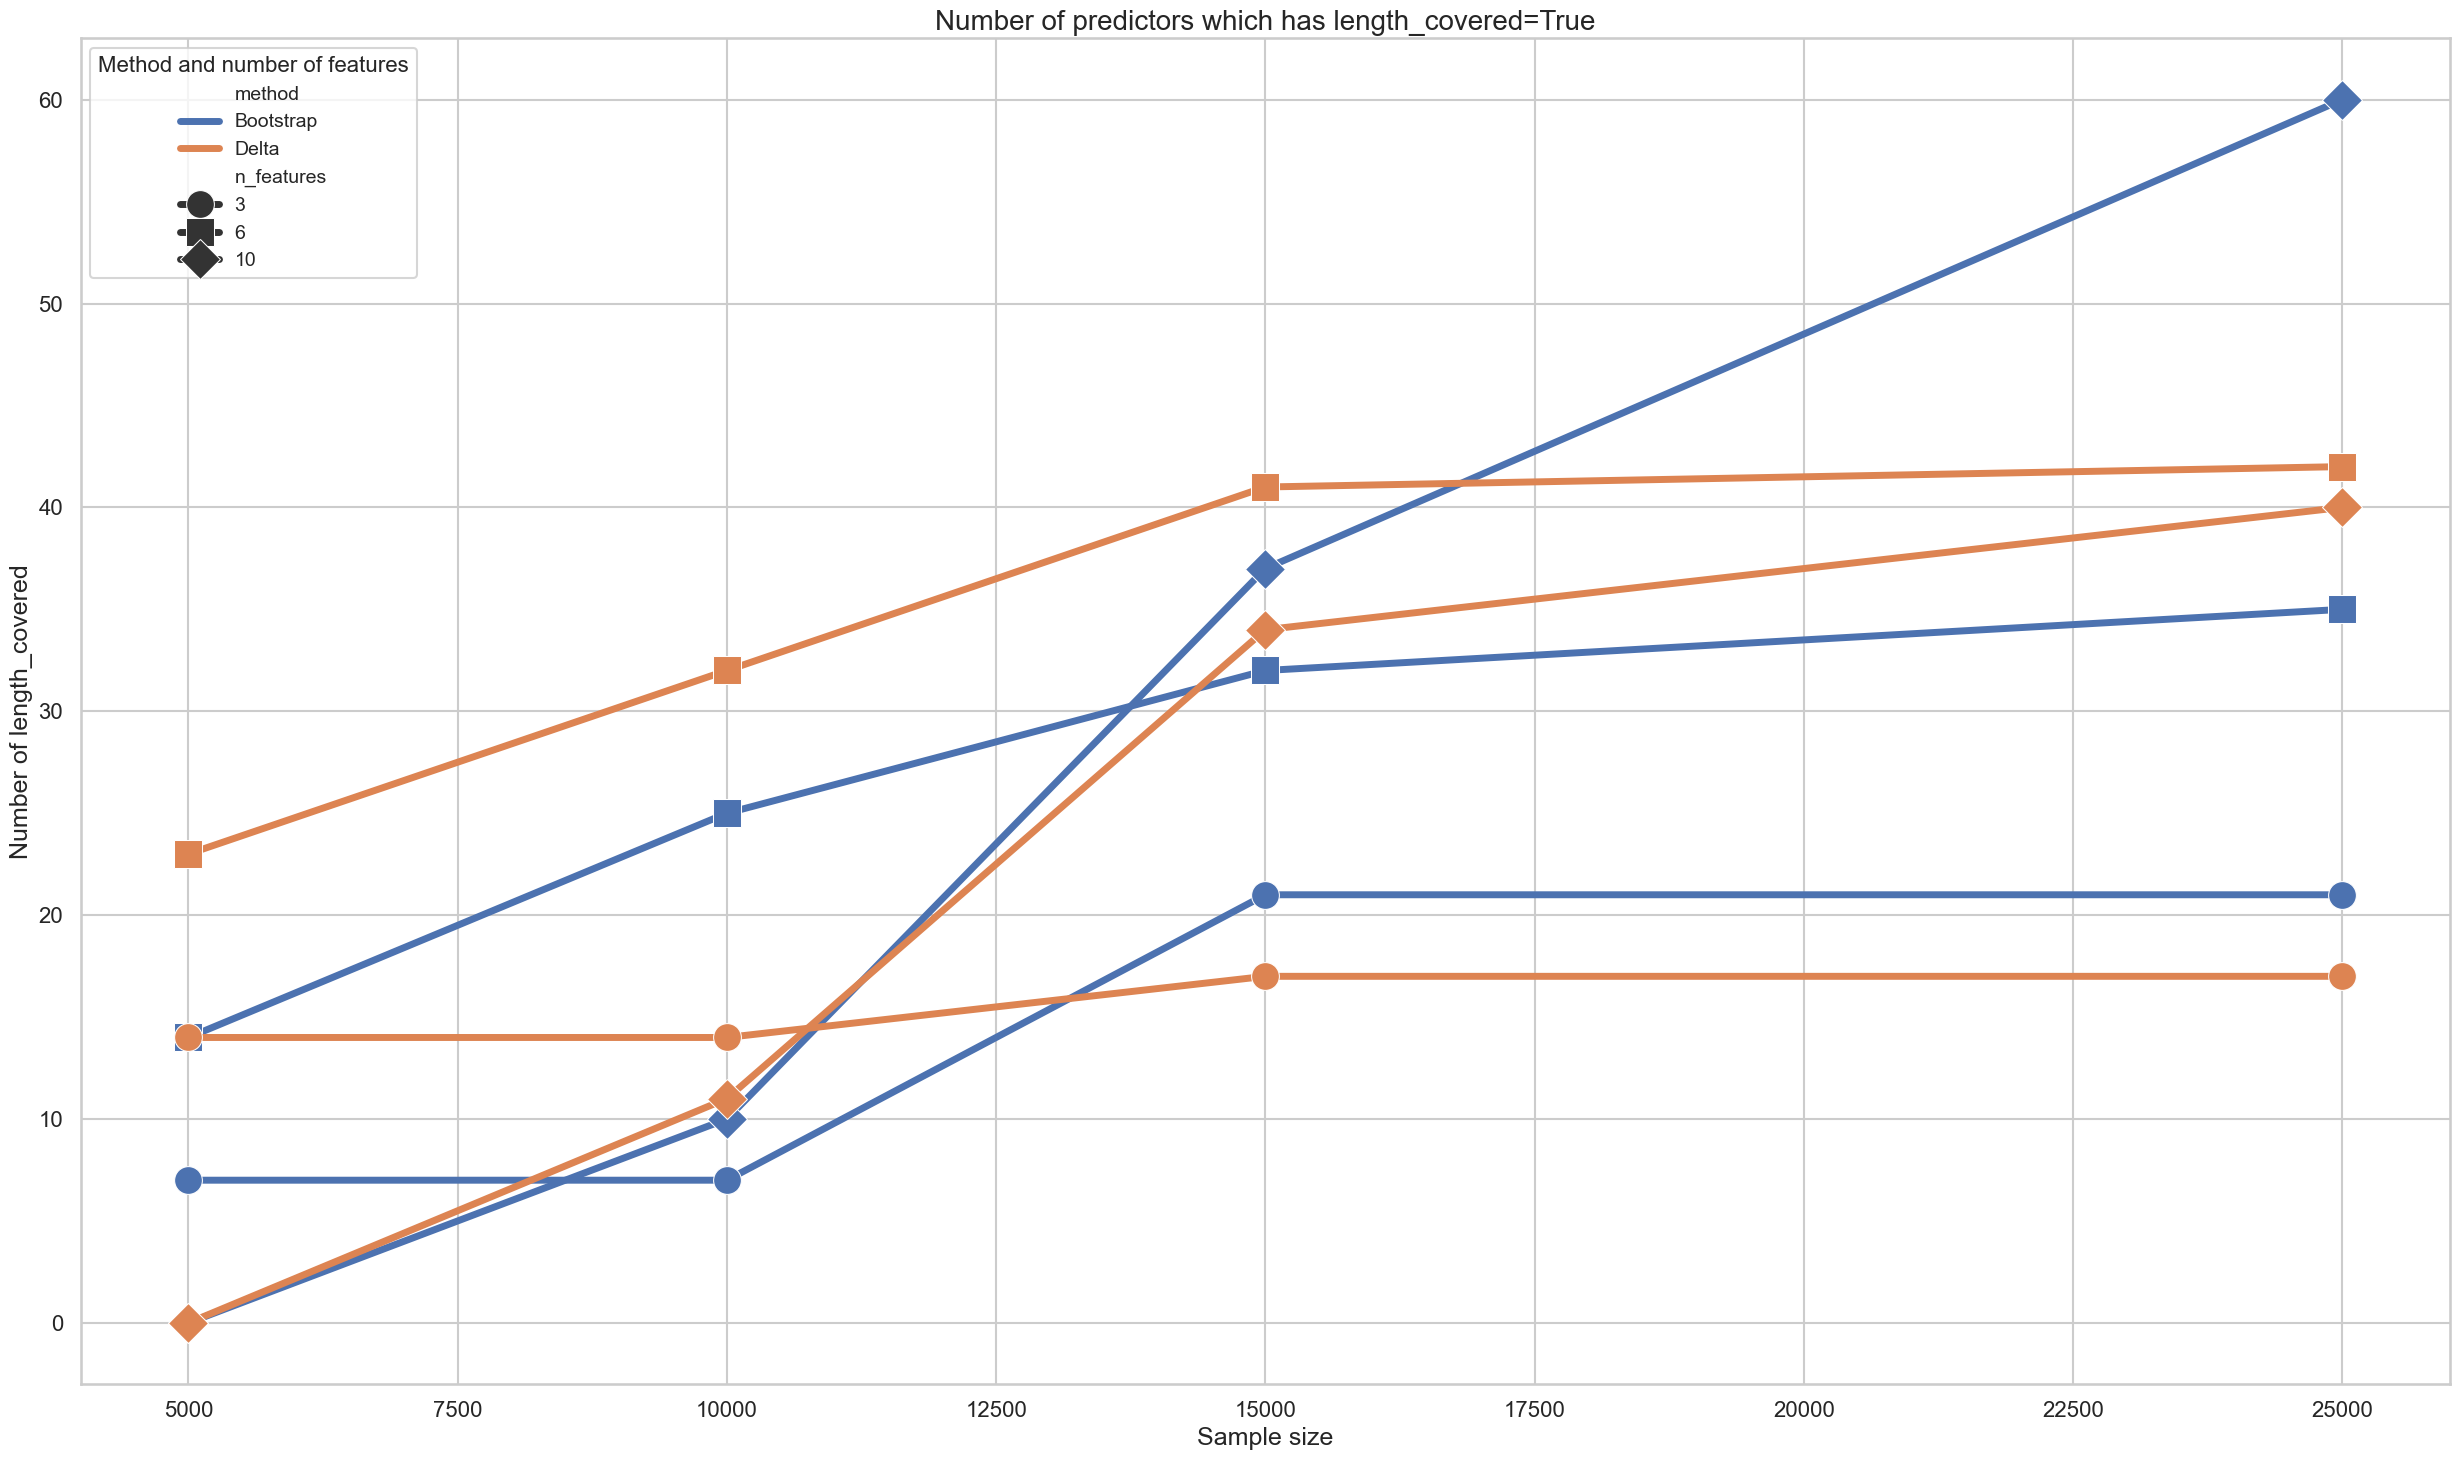

In [21]:
# === 3. Группировка и подсчёт покрытий ===
coverage_summary = combined_all.groupby(['method', 'sample_size', 'n_features'])['length_covered'].sum().reset_index()


# Маркеры для разных n_features
markers_map = {3: "o", 6: "s", 10: "D"}  # круг, квадрат, ромб
sns.set(style="whitegrid")


# Настройка стиля и масштаба шрифта
sns.set(style="whitegrid", context="talk")  # 'talk' увеличивает шрифт
plt.rcParams.update({'font.size': 20})  # дополнительное увеличение

# === Построение графика ===
plt.figure(figsize=(25, 15))
sns.lineplot(
    data=coverage_summary,
    x='sample_size',
    y='length_covered',
    hue='method',
    style='n_features',
    markers=markers_map,
    dashes=False,
    linewidth=5,       # толщина линий
    markersize=20      # размер маркеров
)

plt.title('Number of predictors which has length_covered=True', fontsize=20)
plt.xlabel('Sample size', fontsize=18)
plt.ylabel('Number of length_covered', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Method and number of features', fontsize=14, title_fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()

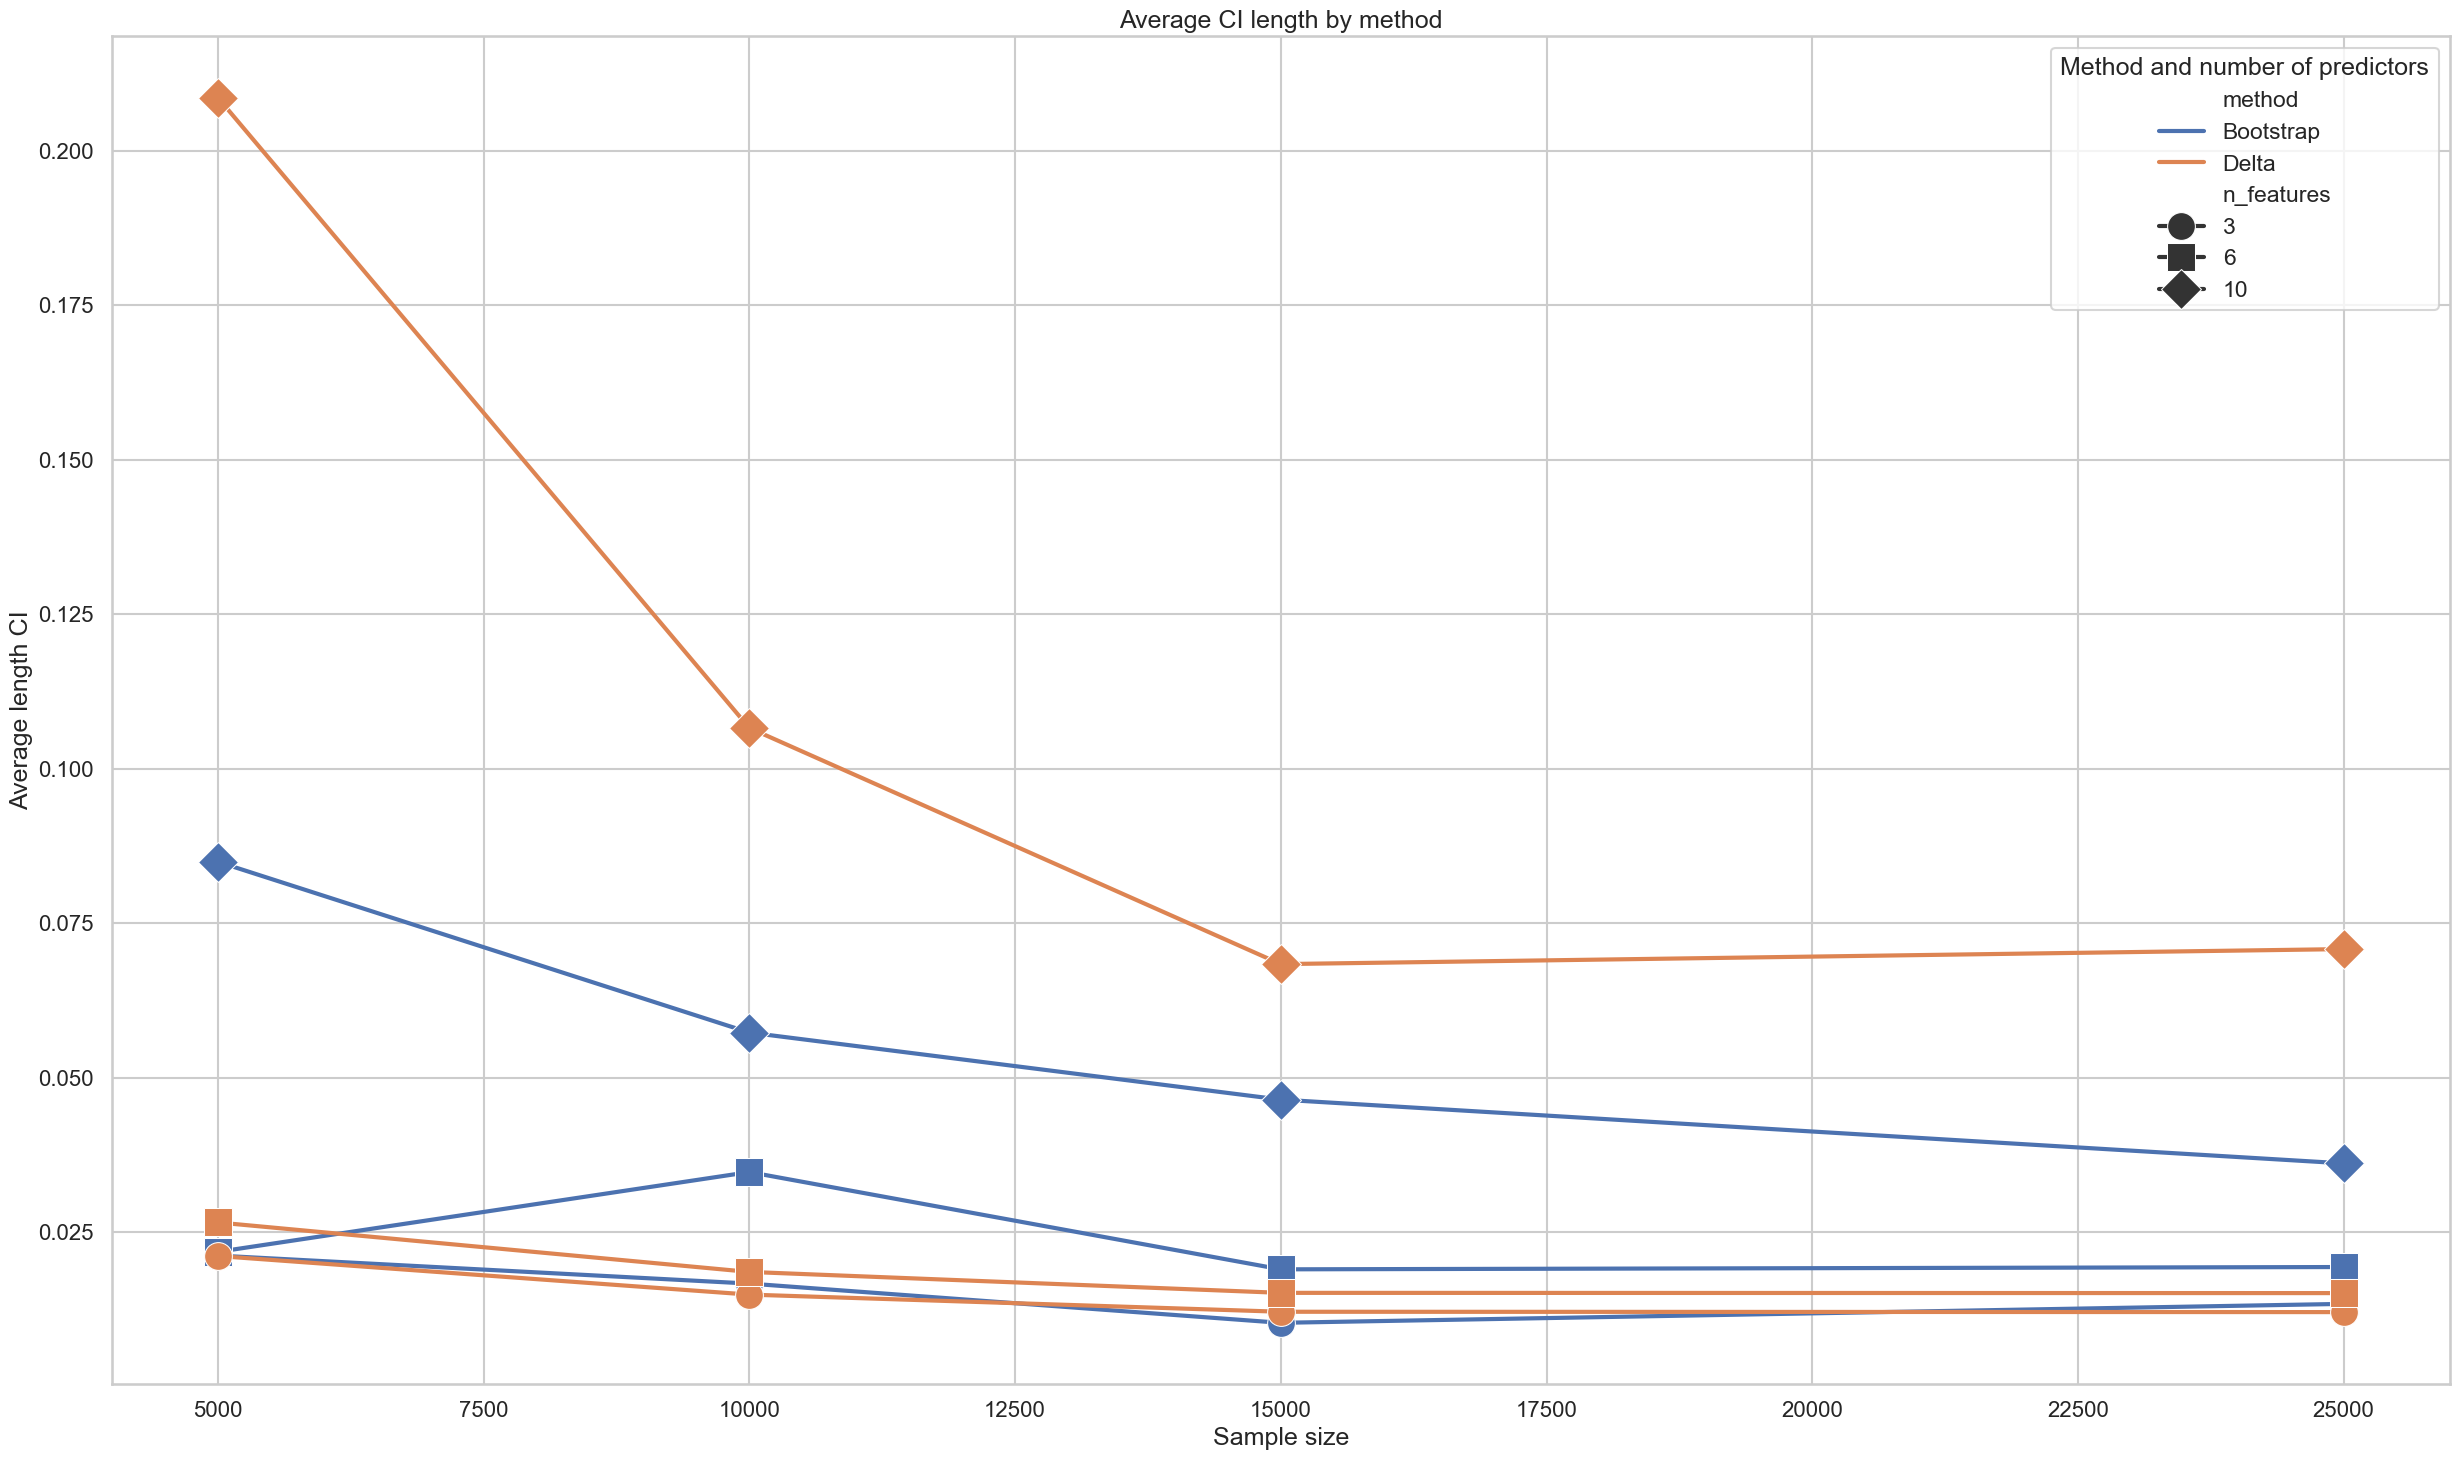

In [39]:
# Группировка
length_summary = combined_all.groupby(['method', 'sample_size', 'n_features'])['ci_length'].mean().reset_index()

# Маркеры для разных n_features
markers_map = {3: "o", 6: "s", 10: "D"}  # круг, квадрат, ромб
sns.set(style="whitegrid")

# Настройка стиля и масштаба шрифта
sns.set(style="whitegrid", context="talk")  # 'talk' увеличивает шрифт
plt.rcParams.update({'font.size': 20})  # дополнительное увеличение

plt.figure(figsize=(25, 15))
sns.lineplot(
    data=length_summary,
    x='sample_size',
    y='ci_length',
    hue='method',
    style='n_features',
    markers=markers_map,
    dashes=False,
    linewidth=3,       # толщина линий
    markersize=20      # размер маркеров
)

plt.title('Average CI length by method')
plt.xlabel('Sample size', fontsize=18)
plt.ylabel('Average length CI', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(title='Method and number of predictors')
plt.tight_layout()
plt.show()

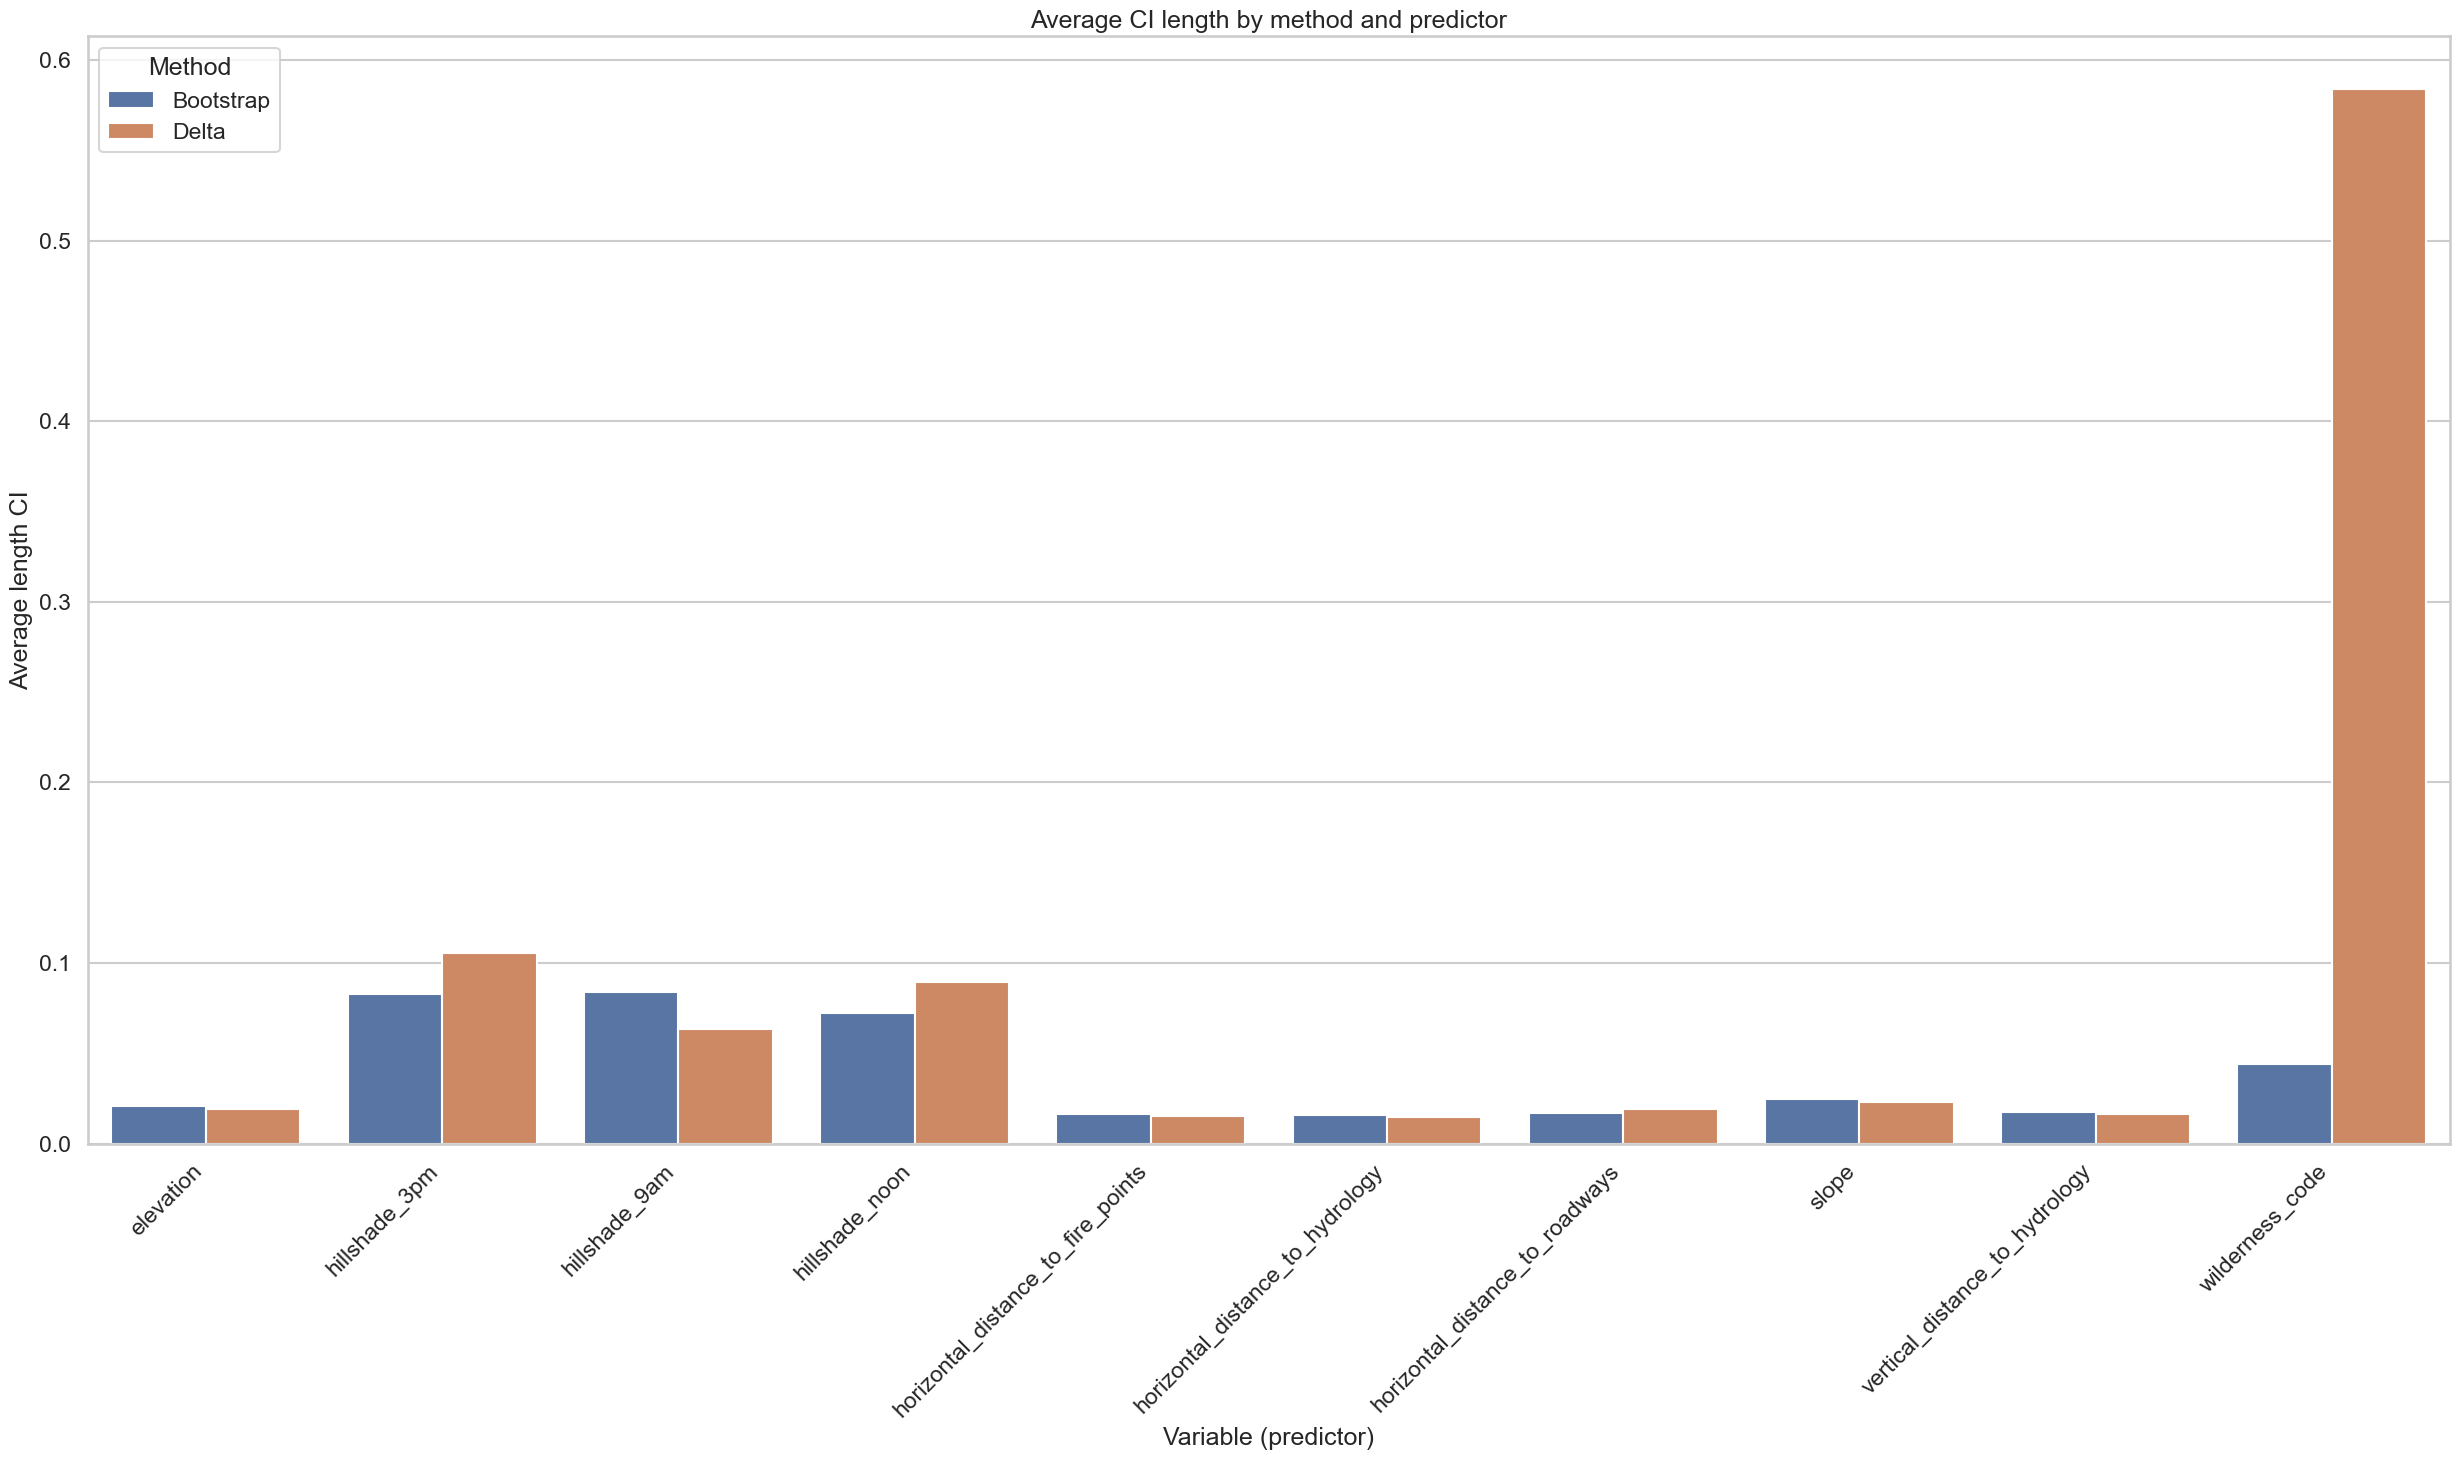

In [23]:
# === 3. Группировка: средняя длина интервалов по методу и признаку
avg_lengths = combined_all.groupby(['method', 'predictor'])['ci_length'].mean().reset_index()

# === 4. Построение графика ===
plt.figure(figsize=(25, 15))
sns.barplot(data=avg_lengths, x='predictor', y='ci_length', hue='method')

plt.title('Average CI length by method and predictor')
plt.xlabel('Variable (predictor)')
plt.ylabel('Average length CI')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Method')
plt.tight_layout()
plt.show()

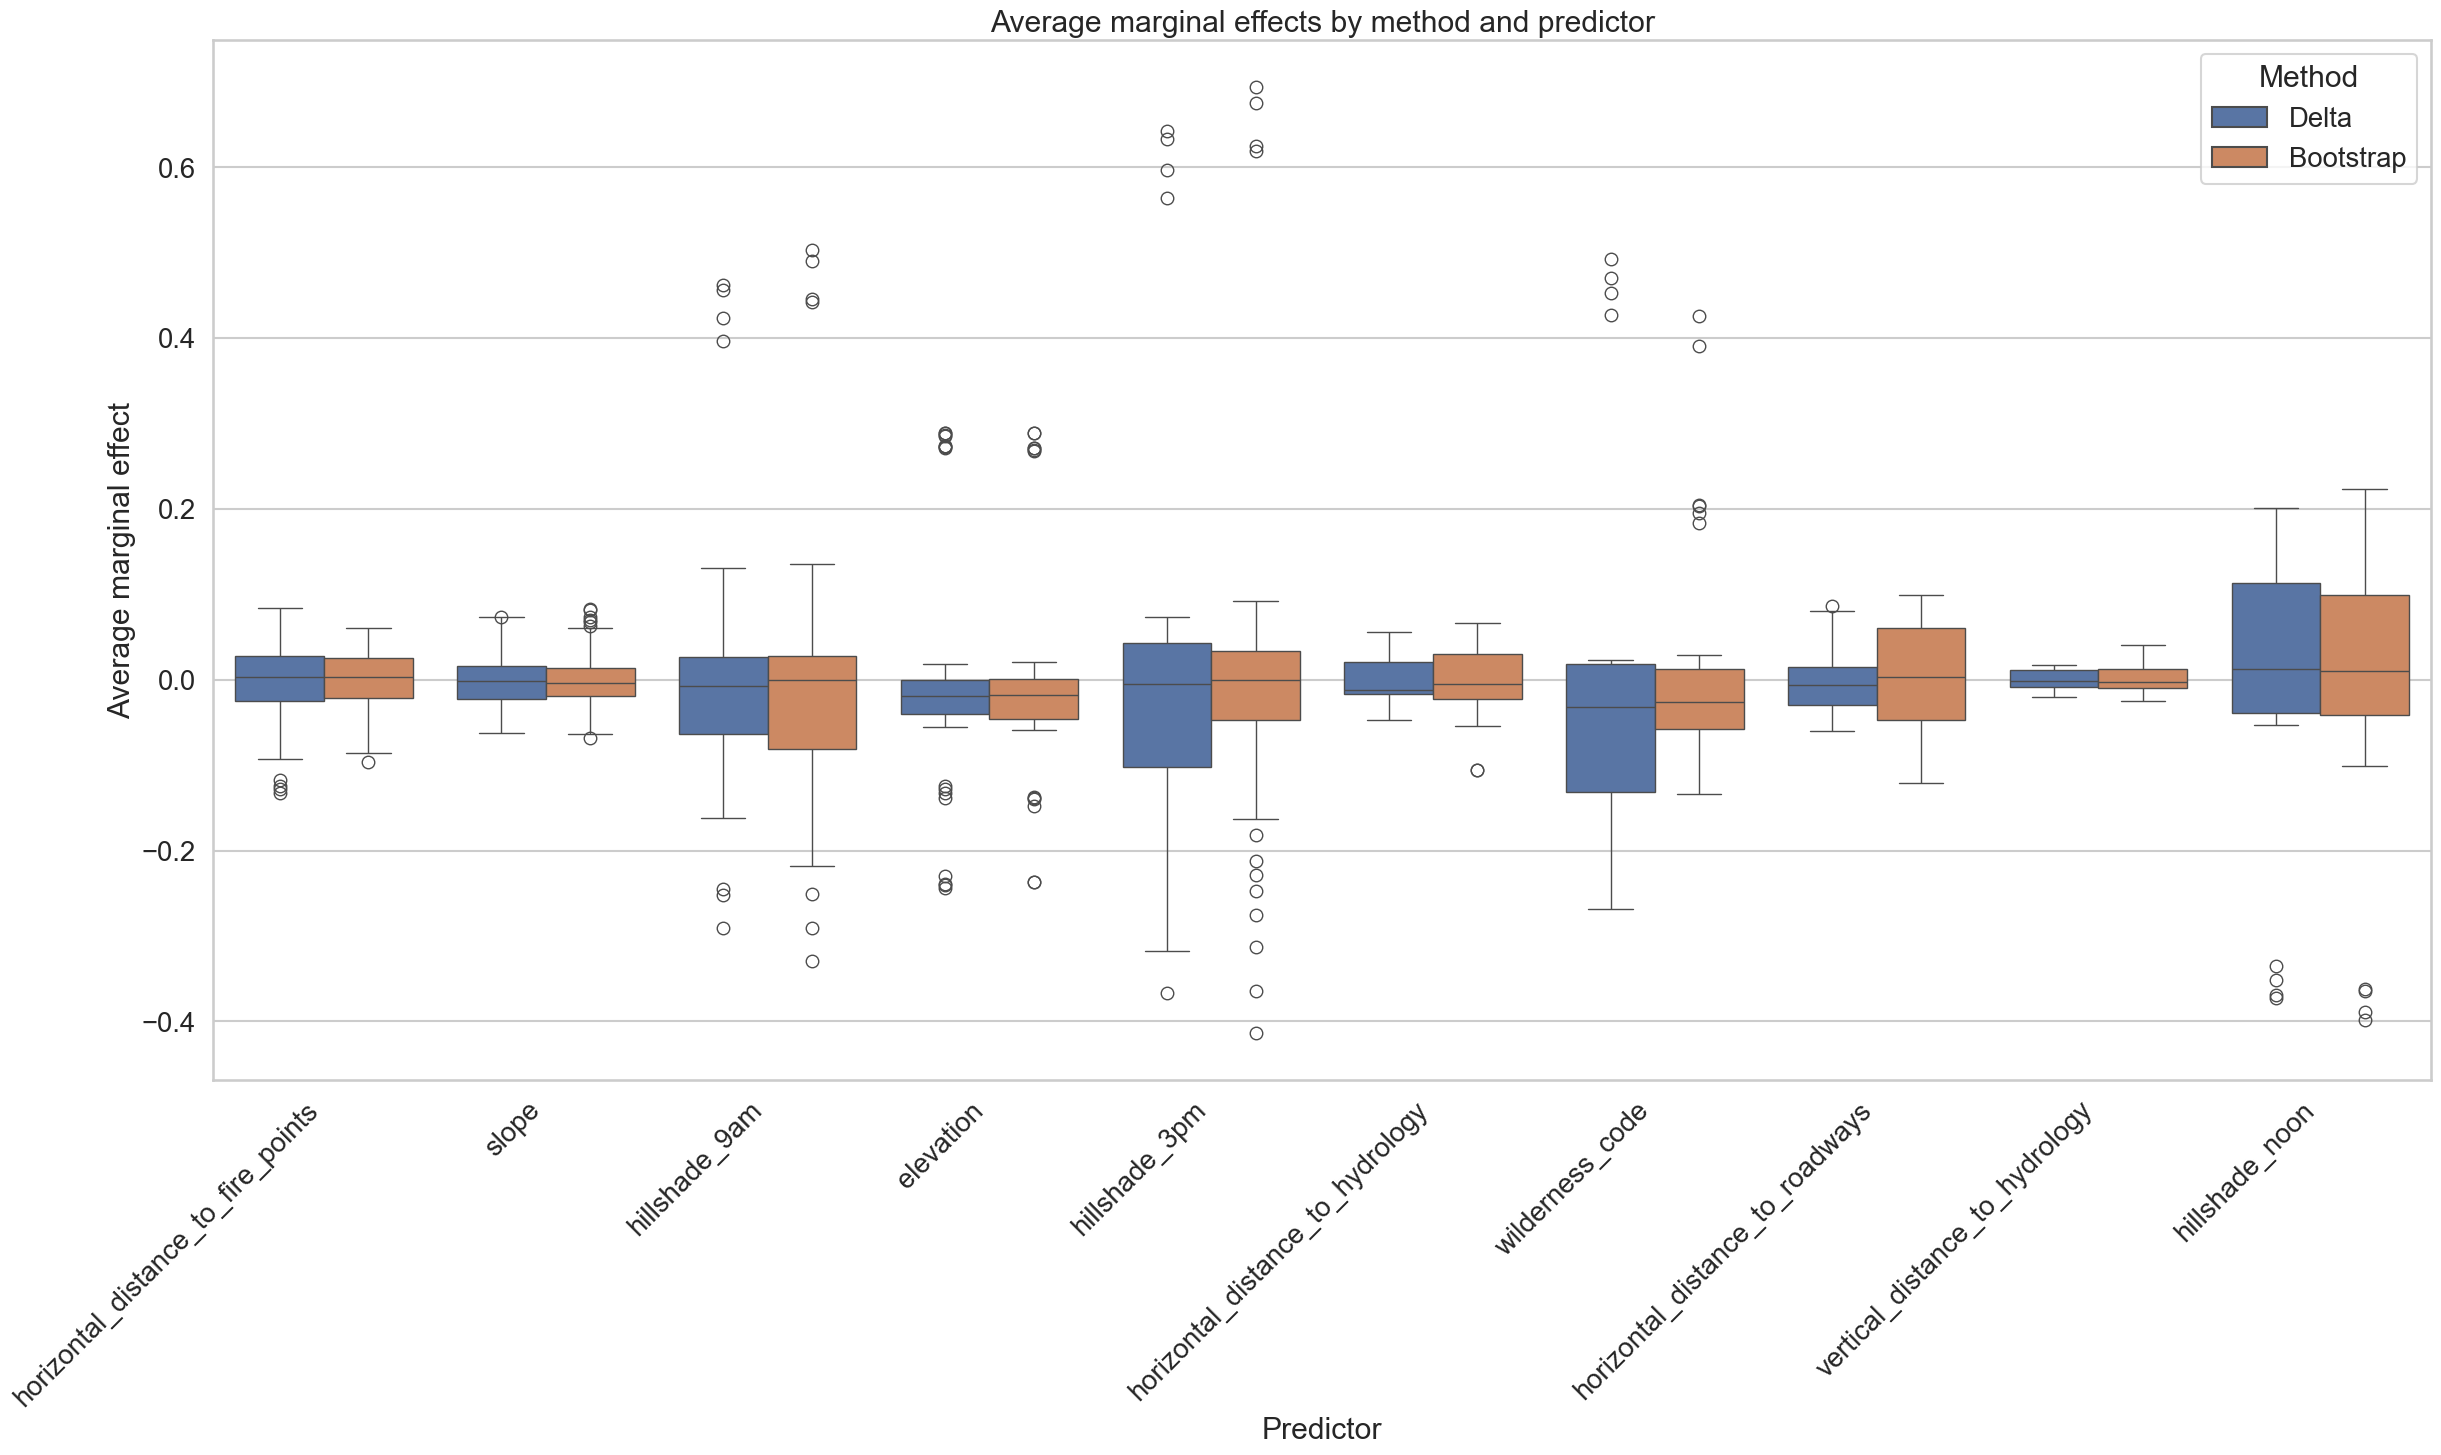

In [429]:
# === Построение boxplot ===
sns.set_context("talk", font_scale=1.2)
plt.figure(figsize=(25, 15))
sns.boxplot(
    data=combined_all,
    x='predictor',
    y='mean_me',
    hue='method',
    showfliers=True,  # показывает выбросы (маленькие кружки)
)

plt.title('Average marginal effects by method and predictor')
plt.xlabel('Predictor')
plt.ylabel('Average marginal effect')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Method')
plt.tight_layout()
plt.show()

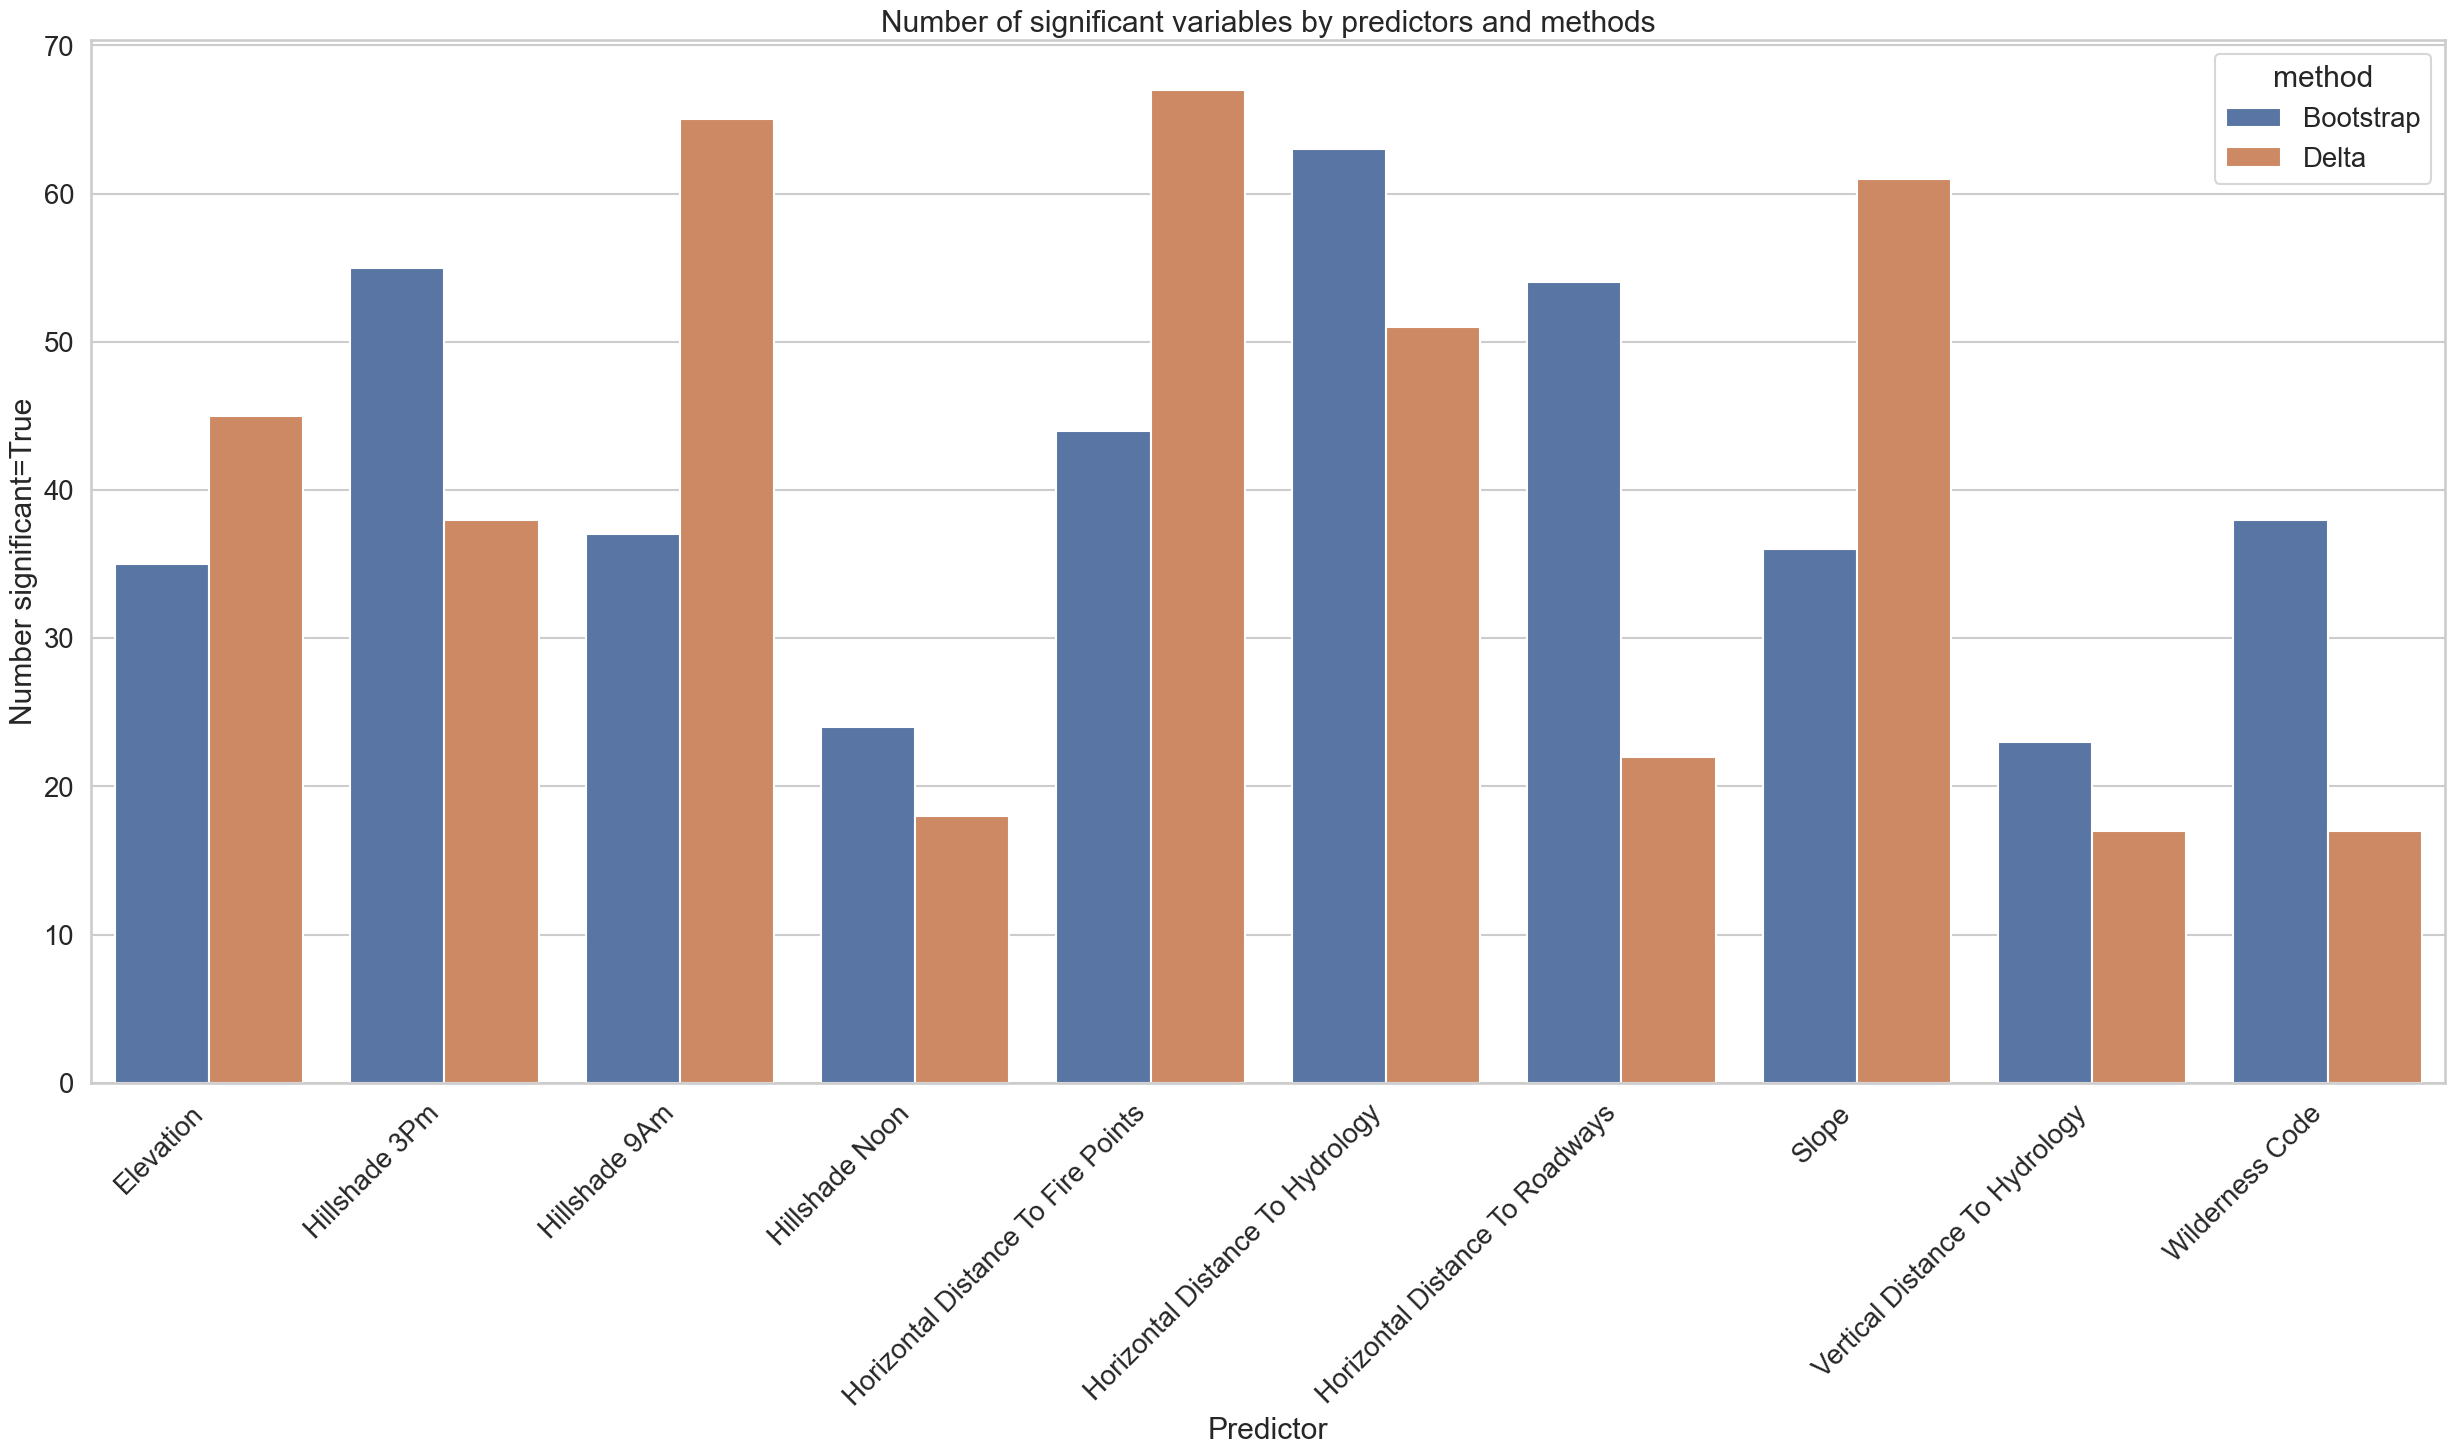

In [437]:
# Подготовка
combined_all['predictor'] = combined_all['predictor'].astype(str).str.strip().str.replace('_', ' ').str.title()

# Группировка
sig_by_predictor = (
    combined_all[combined_all['significant'] == True]
    .groupby(['predictor', 'method'])
    .size()
    .reset_index(name='count')
)

# Построение
plt.figure(figsize=(25, 15))
sns.barplot(data=sig_by_predictor, x='predictor', y='count', hue='method')

plt.title('Number of significant variables by predictors and methods')
plt.xlabel('Predictor')
plt.ylabel('Number significant=True')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()